### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'KRAS'
metric = 'aupr'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'optimizers_plots'
)

### Get coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df = ll_nz_coefs_df[ll_nz_coefs_df.gene == plot_gene].copy()
ll_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,KRAS,signal,50.0,42,0,5483
1,KRAS,signal,50.0,42,1,5446
2,KRAS,signal,50.0,42,2,5540
3,KRAS,signal,50.0,42,3,5771
4,KRAS,signal,5.0,42,0,2702


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df = sgd_nz_coefs_df[sgd_nz_coefs_df.gene == plot_gene].copy()
sgd_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,KRAS,signal,0.000001,42,0,15367
1,KRAS,signal,0.000001,42,1,15371
2,KRAS,signal,0.000001,42,2,15372
3,KRAS,signal,0.000001,42,3,15371
4,KRAS,signal,5.000000,42,0,0


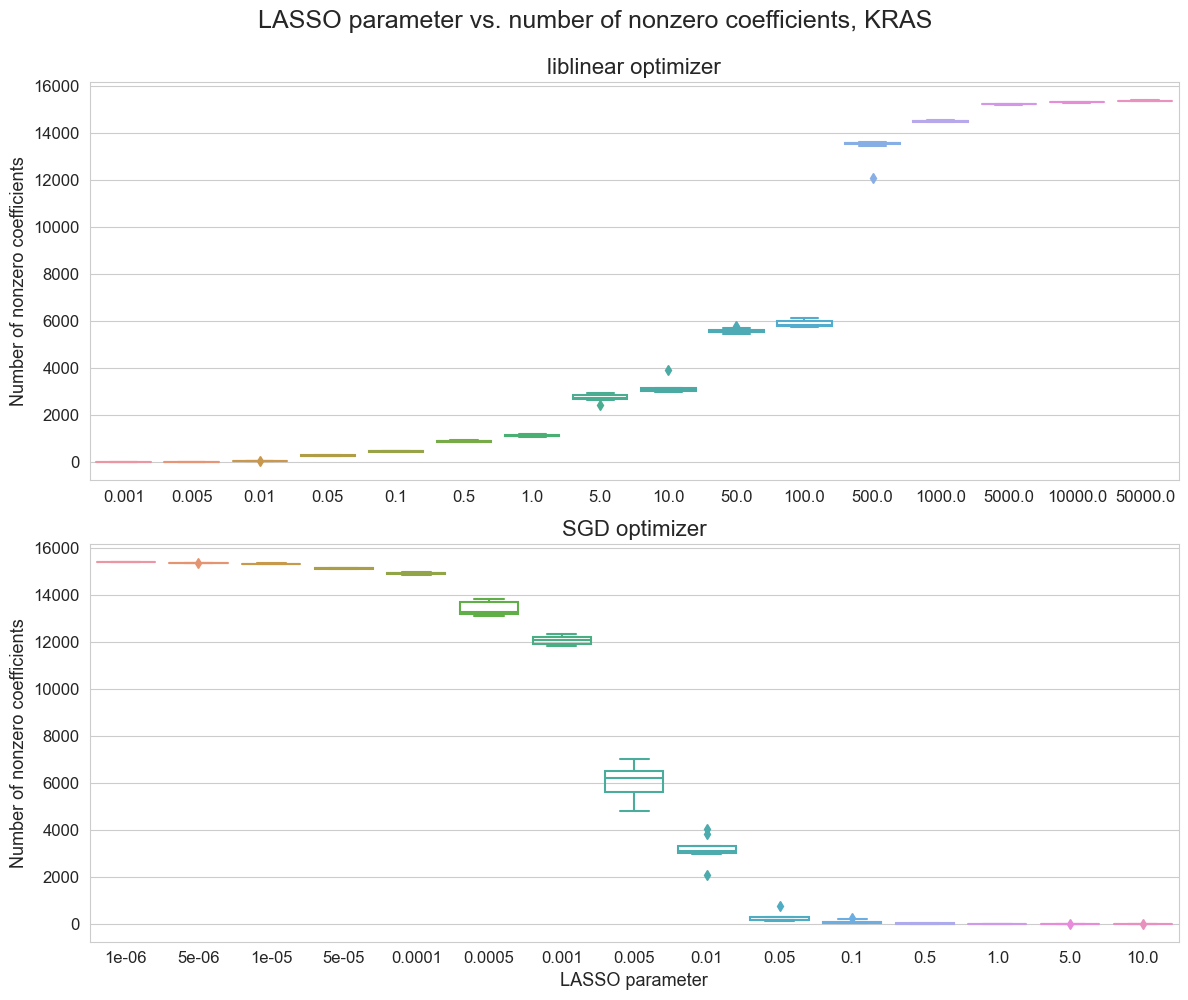

In [5]:
sns.set({'figure.figsize': (12, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[0]
)
axarr[0].set_title('liblinear optimizer', size=16)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Number of nonzero coefficients', size=13)
axarr[0].tick_params(axis='both', labelsize=12)

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[1]
)
axarr[1].set_title('SGD optimizer', size=16)
axarr[1].set_xlabel('LASSO parameter', size=13)
axarr[1].set_ylabel('Number of nonzero coefficients', size=13)
axarr[1].tick_params(axis='both', labelsize=12)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
color_boxes(axarr[0])
color_boxes(axarr[1])

plt.suptitle(
    f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}',
    size=18, y=0.995
)

plt.tight_layout()

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefs_count.svg'), bbox_inches='tight')

### Get performance information for each lasso penalty

In [6]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,KRAS,signal,42,train,0,5000.0
1,0.71214,0.37021,KRAS,signal,42,test,0,5000.0
2,0.80092,0.52221,KRAS,signal,42,cv,0,5000.0
3,1.00000,1.00000,KRAS,signal,42,train,1,5000.0
4,0.78029,0.48865,KRAS,signal,42,test,1,5000.0


In [7]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'stratified',
                                                     gene=plot_gene)
sgd_perf_df = (
    sgd_perf_df[sgd_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,KRAS,signal,42,train,0,5e-06
1,0.79175,0.55335,KRAS,signal,42,test,0,5e-06
2,0.80626,0.59862,KRAS,signal,42,cv,0,5e-06
3,1.00000,1.00000,KRAS,signal,42,train,1,5e-06
4,0.82374,0.61336,KRAS,signal,42,test,1,5e-06


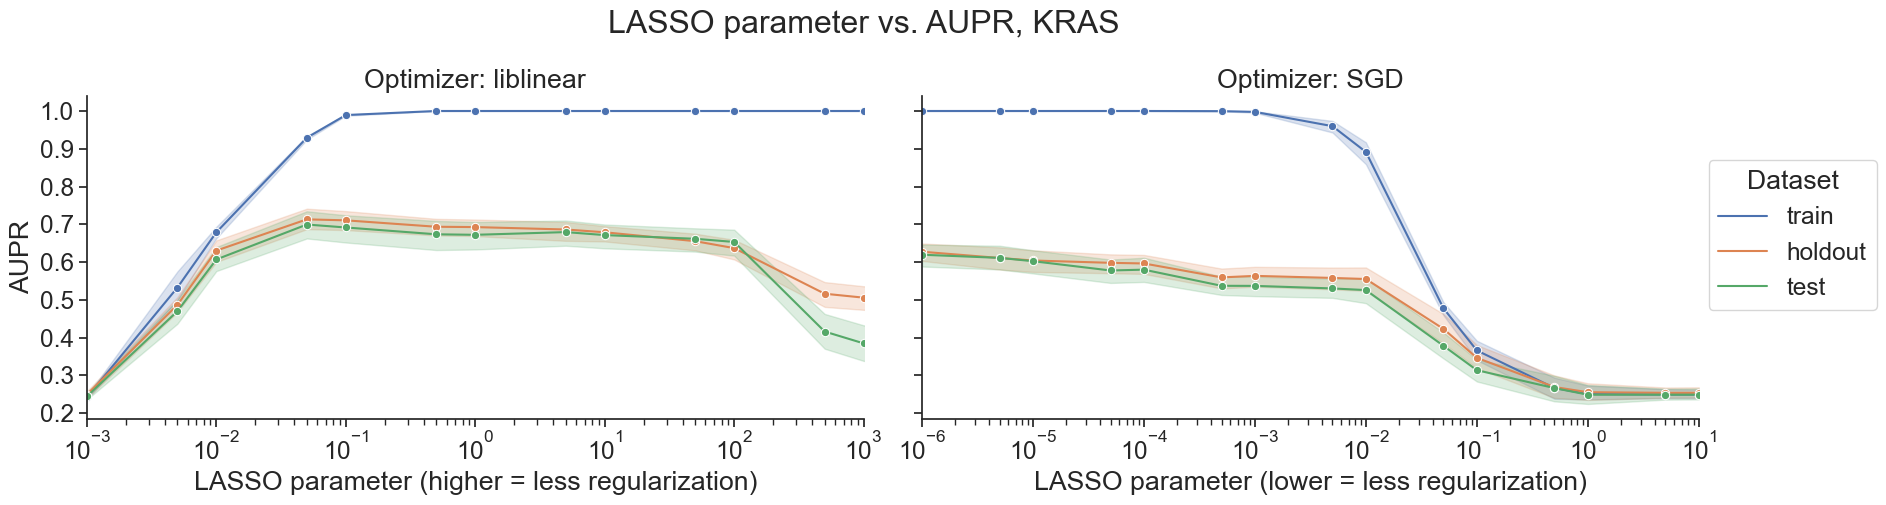

In [8]:
sns.set_style('ticks')

ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

ll_plot_df['optimizer'] = 'liblinear'
sgd_plot_df['optimizer'] = 'SGD'

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e2))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-7, 10))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.0)

plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_parameter_vs_perf.svg'), bbox_inches='tight')

In [9]:
ll_nz_coefs_df['optimizer'] = 'liblinear'
sgd_nz_coefs_df['optimizer'] = 'SGD'

nz_coefs_df = pd.concat((ll_nz_coefs_df, sgd_nz_coefs_df))
nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs,optimizer
0,KRAS,signal,50.0,42,0,5483,liblinear
1,KRAS,signal,50.0,42,1,5446,liblinear
2,KRAS,signal,50.0,42,2,5540,liblinear
3,KRAS,signal,50.0,42,3,5771,liblinear
4,KRAS,signal,5.0,42,0,2702,liblinear


In [10]:
perf_coefs_df = (plot_df
    .merge(nz_coefs_df,
           left_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'],
           right_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'])
)

print(perf_coefs_df.shape)
perf_coefs_df.head()

(744, 11)


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs
0,0.5,0.26399,KRAS,signal,42,cv,3,0.001,liblinear,signal,0
1,0.5,0.23994,KRAS,signal,42,train,3,0.001,liblinear,signal,0
2,0.5,0.23420,KRAS,signal,42,test,3,0.001,liblinear,signal,0
3,0.5,0.23386,KRAS,signal,1,test,0,0.001,liblinear,signal,0
4,0.5,0.24856,KRAS,signal,1,cv,0,0.001,liblinear,signal,0


,quantile,value
0,0.1,0.0
1,0.2,22.0
2,0.3,270.0
3,0.4,1115.0
4,0.5,3133.0
5,0.6,6271.0
6,0.7,13663.0
7,0.8,15134.0
8,0.9,15319.7


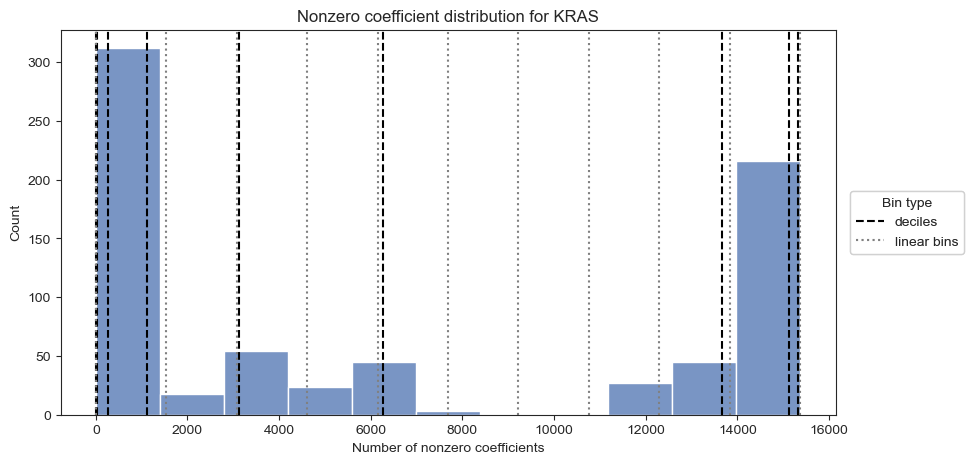

In [11]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('ticks')
sns.histplot(perf_coefs_df.nz_coefs)
plt.title(f'Nonzero coefficient distribution for {plot_gene}')
plt.xlabel('Number of nonzero coefficients')

linear_bins_df = []
quantiles_df = []

ax = plt.gca()
for q in np.linspace(0.1, 0.9, 9):
    quantiles_df.append([q, perf_coefs_df.nz_coefs.quantile(q)])
    ax.axvline(x=perf_coefs_df.nz_coefs.quantile(q),
                      color='black', linestyle='--')
    
for b in np.linspace(0, perf_coefs_df.nz_coefs.max(), 11):
    ax.axvline(x=b, color='grey', linestyle=':')
    
# create custom legend for bin boundary lines
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--'),
    Line2D([0], [0], color='grey', linestyle=':'),
]
legend_labels = ['deciles', 'linear bins']
l = ax.legend(legend_handles, legend_labels, title='Bin type',
              loc='lower left', bbox_to_anchor=(1.01, 0.4))
ax.add_artist(l)
    
quantiles_df = pd.DataFrame(quantiles_df, columns=['quantile', 'value'])
quantiles_df

In [12]:
# TODO: figure out 0 quantile general solution
perf_coefs_df['nz_linear_bin'] = pd.cut(
    perf_coefs_df.nz_coefs,
    bins=np.linspace(0, perf_coefs_df.nz_coefs.max(), 11),
    labels=[f'{q}' for q in range(1, 11)],
    include_lowest=True
)

print(perf_coefs_df.nz_linear_bin.unique().sort_values())
perf_coefs_df.head()

['1', '2', '3', '4', '5', '8', '9', '10']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin
0,0.5,0.26399,KRAS,signal,42,cv,3,0.001,liblinear,signal,0,1
1,0.5,0.23994,KRAS,signal,42,train,3,0.001,liblinear,signal,0,1
2,0.5,0.23420,KRAS,signal,42,test,3,0.001,liblinear,signal,0,1
3,0.5,0.23386,KRAS,signal,1,test,0,0.001,liblinear,signal,0,1
4,0.5,0.24856,KRAS,signal,1,cv,0,0.001,liblinear,signal,0,1


In [13]:
ll_param_bin_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'liblinear']
).loc[:, ['lasso_param', 'nz_linear_bin']]

(ll_param_bin_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_linear_bin'].apply(list)

lasso_param
0.001           [1]
0.005           [1]
0.010           [1]
0.050           [1]
0.100           [1]
0.500           [1]
1.000           [1]
5.000           [2]
10.000       [3, 2]
50.000          [4]
100.000         [4]
500.000      [9, 8]
1000.000       [10]
5000.000       [10]
10000.000      [10]
50000.000      [10]
Name: nz_linear_bin, dtype: object

In [14]:
sgd_param_bin_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'SGD']
).loc[:, ['lasso_param', 'nz_linear_bin']]

(sgd_param_bin_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_linear_bin'].apply(list)

lasso_param
0.000001       [10]
0.000005       [10]
0.000010       [10]
0.000050       [10]
0.000100       [10]
0.000500        [9]
0.001000     [8, 9]
0.005000     [4, 5]
0.010000     [2, 3]
0.050000        [1]
0.100000        [1]
0.500000        [1]
1.000000        [1]
5.000000        [1]
10.000000       [1]
Name: nz_linear_bin, dtype: object

[1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]


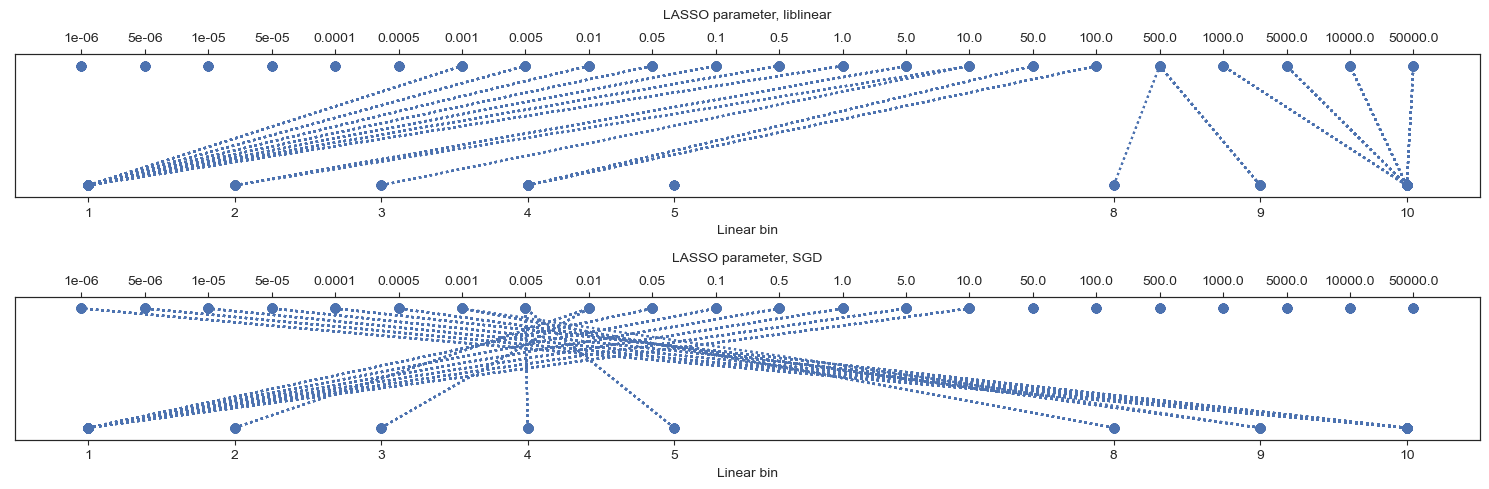

In [15]:
sns.set({'figure.figsize': (15, 5)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

param_bin_map = perf_coefs_df.loc[:, ['lasso_param', 'nz_linear_bin']]

# ax1 is the bin axis for liblinear
ax1 = axarr[0]
ax1.scatter(x=param_bin_map.nz_linear_bin.astype(int).values,
            y=[0] * param_bin_map.shape[0])
ax1.set_xlim(param_bin_map.nz_linear_bin.astype(int).min() - 0.5,
             param_bin_map.nz_linear_bin.astype(int).max() + 0.5)
ax1.set_xticks(param_bin_map.nz_linear_bin.astype(int).unique())
ax1.get_yaxis().set_visible(False)
ax1.set_xlabel('Linear bin')

ax2 = ax1.twiny()
param_vals = param_bin_map.lasso_param.sort_values(ascending=True).astype(str)
ax2.scatter(x=param_vals, y=[1] * param_bin_map.shape[0])
ax2.set_xlabel('LASSO parameter, liblinear', labelpad=10)

def bins_to_coords(bins):
    # TODO document
    x = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 11)
    # https://stackoverflow.com/a/23856065
    x_mid = (x[1:] + x[:-1]) / 2
    return {b: x_mid[int(b)-1] for b in bins}

# iterate through all (param, bin) coordinates and use bin to index
bins = param_bin_map.nz_linear_bin.astype(int).sort_values(ascending=True).unique().tolist()
b_to_c = bins_to_coords(bins)

unique_param_vals = param_vals.astype(float).unique().tolist()
for ix, row in ll_param_bin_map.iterrows():
    bin_ix = int(row.nz_linear_bin)
    lasso_param_ix = unique_param_vals.index(row.lasso_param) 
    ax2.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
ax1.set_ylim(-0.1, 1.1)
ax1.set_yticks([0, 1])

# ax3 is the bin axis for SGD
ax3 = axarr[1]
ax3.scatter(x=param_bin_map.nz_linear_bin.astype(int).values,
            y=[0] * param_bin_map.shape[0])
ax3.set_xlim(param_bin_map.nz_linear_bin.astype(int).min() - 0.5,
             param_bin_map.nz_linear_bin.astype(int).max() + 0.5)
ax3.set_xticks(param_bin_map.nz_linear_bin.astype(int).unique())
ax3.get_yaxis().set_visible(False)
ax3.set_xlabel('Linear bin')

ax4 = ax3.twiny()
param_vals = param_bin_map.lasso_param.sort_values(ascending=True).astype(str)
ax4.scatter(x=param_vals, y=[1] * param_bin_map.shape[0])
ax4.set_xlabel('LASSO parameter, SGD', labelpad=10)

unique_param_vals = param_vals.astype(float).unique().tolist()
print(unique_param_vals)
for ix, row in sgd_param_bin_map.iterrows():
    bin_ix = int(row.nz_linear_bin)
    lasso_param_ix = unique_param_vals.index(row.lasso_param) 
    ax4.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
ax3.set_ylim(-0.1, 1.1)
ax3.set_yticks([0, 1])

plt.tight_layout()

In [16]:
# sometimes there are enough classifiers with O nonzero coefficients, or the
# max number of coefficients, such that they are covered by a whole decile
# in that case, we drop the duplicate deciles and combine them into one (so we'll
# have e.g. 9 bins instead of 10 deciles)
range_bounds = (0.0, float(perf_coefs_df.nz_coefs.max()))
print(range_bounds)

num_quantiles = quantiles_df[~quantiles_df.value.isin(range_bounds)].shape[0]
print(num_quantiles, 'unique quantiles')

perf_coefs_df['nz_quantile'] = pd.qcut(
    perf_coefs_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, num_quantiles+2)],
    duplicates='drop'
)

print(perf_coefs_df.nz_quantile.unique().sort_values())
perf_coefs_df.head()

(0.0, 15374.0)
8 unique quantiles
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Categories (9, object): ['1' < '2' < '3' < '4' ... '6' < '7' < '8' < '9']


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs,nz_linear_bin,nz_quantile
0,0.5,0.26399,KRAS,signal,42,cv,3,0.001,liblinear,signal,0,1,1
1,0.5,0.23994,KRAS,signal,42,train,3,0.001,liblinear,signal,0,1,1
2,0.5,0.23420,KRAS,signal,42,test,3,0.001,liblinear,signal,0,1,1
3,0.5,0.23386,KRAS,signal,1,test,0,0.001,liblinear,signal,0,1,1
4,0.5,0.24856,KRAS,signal,1,cv,0,0.001,liblinear,signal,0,1,1


In [17]:
ll_param_q_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'liblinear']                  
).loc[:, ['lasso_param', 'nz_quantile']]

(ll_param_q_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_quantile'].apply(list)

lasso_param
0.001           [1]
0.005           [1]
0.010        [1, 2]
0.050        [2, 3]
0.100           [3]
0.500           [3]
1.000        [4, 3]
5.000           [4]
10.000       [5, 4]
50.000          [5]
100.000         [5]
500.000         [6]
1000.000        [7]
5000.000        [8]
10000.000       [8]
50000.000       [9]
Name: nz_quantile, dtype: object

In [18]:
sgd_param_q_map = (perf_coefs_df
    [perf_coefs_df.optimizer == 'SGD']                  
).loc[:, ['lasso_param', 'nz_quantile']]

(sgd_param_q_map
   .drop_duplicates()
   .groupby('lasso_param')
)['nz_quantile'].apply(list)

lasso_param
0.000001        [9]
0.000005        [9]
0.000010     [8, 9]
0.000050     [7, 8]
0.000100        [7]
0.000500     [7, 6]
0.001000        [6]
0.005000     [5, 6]
0.010000     [4, 5]
0.050000     [2, 3]
0.100000     [2, 1]
0.500000        [1]
1.000000        [1]
5.000000        [1]
10.000000       [1]
Name: nz_quantile, dtype: object

[1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]
[1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]


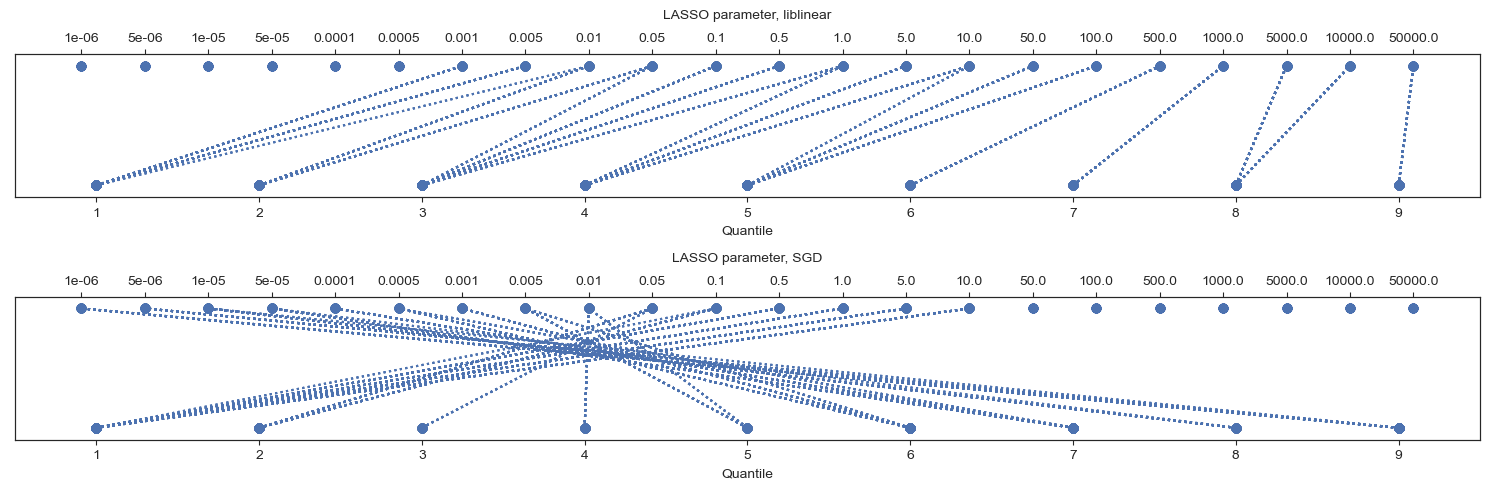

In [19]:
sns.set({'figure.figsize': (15, 5)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

param_q_map = perf_coefs_df.loc[:, ['lasso_param', 'nz_quantile']]

# ax1 is the bin axis for liblinear
ax1 = axarr[0]
ax1.scatter(x=param_q_map.nz_quantile.astype(int).values,
            y=[0] * param_q_map.shape[0])
ax1.set_xlim(param_q_map.nz_quantile.astype(int).min() - 0.5,
             param_q_map.nz_quantile.astype(int).max() + 0.5)
ax1.set_xticks(param_q_map.nz_quantile.astype(int).unique())
ax1.get_yaxis().set_visible(False)
ax1.set_xlabel('Quantile')

ax2 = ax1.twiny()
param_vals = param_q_map.lasso_param.sort_values(ascending=True).astype(str)
ax2.scatter(x=param_vals, y=[1] * param_q_map.shape[0])
ax2.set_xlabel('LASSO parameter, liblinear', labelpad=10)

def bins_to_coords(bins):
    # TODO document
    x = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], len(perf_coefs_df.nz_quantile.unique())+1)
    # https://stackoverflow.com/a/23856065
    x_mid = (x[1:] + x[:-1]) / 2
    return {b: x_mid[int(b)-1] for b in bins}

# iterate through all (param, bin) coordinates and use bin to index
qs = param_q_map.nz_quantile.astype(int).sort_values(ascending=True).unique().tolist()
b_to_c = bins_to_coords(qs)

unique_param_vals = param_vals.astype(float).unique().tolist()
print(unique_param_vals)
for ix, row in ll_param_q_map.iterrows():
    bin_ix = int(row.nz_quantile)
    lasso_param_ix = unique_param_vals.index(row.lasso_param) 
    ax2.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
ax1.set_ylim(-0.1, 1.1)
ax1.set_yticks([0, 1])

# ax3 is the bin axis for SGD
ax3 = axarr[1]
ax3.scatter(x=param_q_map.nz_quantile.astype(int).values,
            y=[0] * param_q_map.shape[0])
ax3.set_xlim(param_q_map.nz_quantile.astype(int).min() - 0.5,
             param_q_map.nz_quantile.astype(int).max() + 0.5)
ax3.set_xticks(param_q_map.nz_quantile.astype(int).unique())
ax3.get_yaxis().set_visible(False)
ax3.set_xlabel('Quantile')

ax4 = ax3.twiny()
param_vals = param_q_map.lasso_param.sort_values(ascending=True).astype(str)
ax4.scatter(x=param_vals, y=[1] * param_q_map.shape[0])
ax4.set_xlabel('LASSO parameter, SGD', labelpad=10)

unique_param_vals = param_vals.astype(float).unique().tolist()
print(unique_param_vals)
for ix, row in sgd_param_q_map.iterrows():
    bin_ix = int(row.nz_quantile)
    lasso_param_ix = unique_param_vals.index(row.lasso_param) 
    ax4.plot([b_to_c[bin_ix], lasso_param_ix], [0, 1], 'bo:')
ax3.set_ylim(-0.1, 1.1)
ax3.set_yticks([0, 1])

plt.tight_layout()

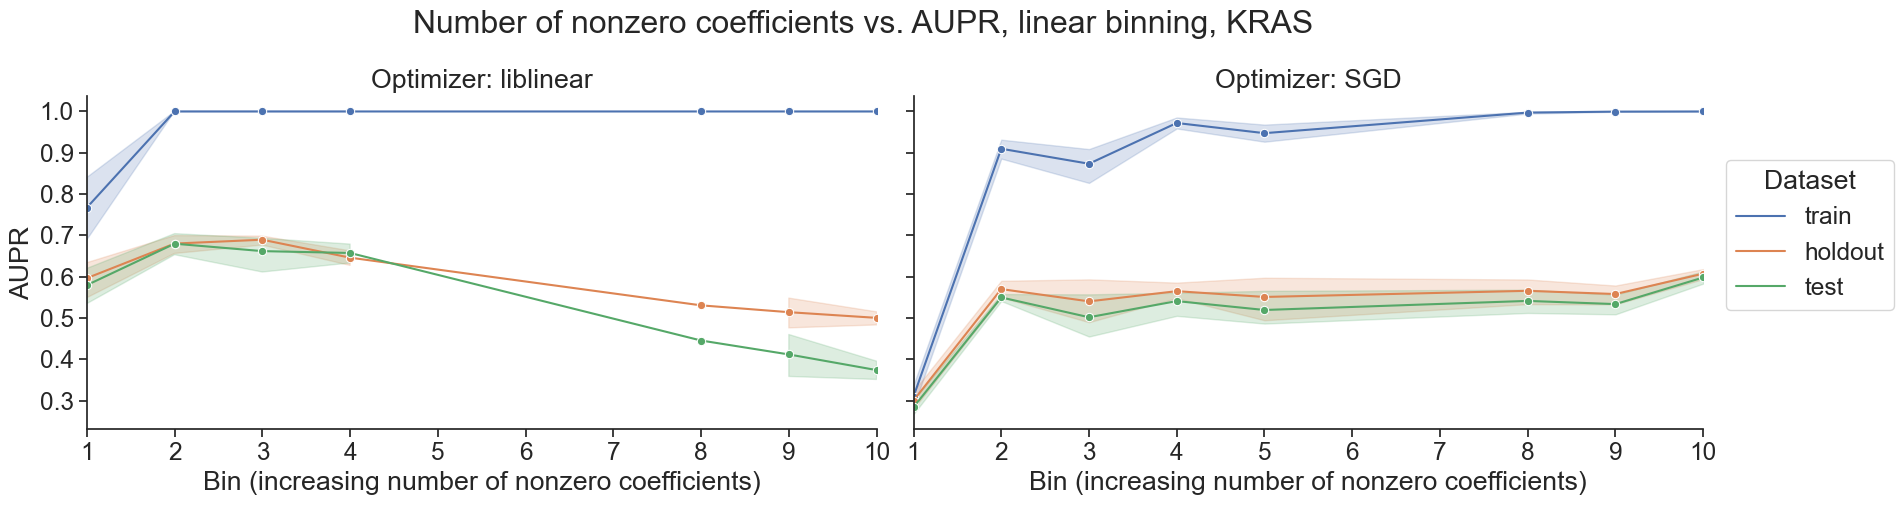

In [20]:
sns.set_style('ticks')

ll_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'liblinear')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

sgd_plot_df = (
    perf_coefs_df[(perf_coefs_df.optimizer == 'sgd')]
      .sort_values(by=['nz_linear_bin'])
      .reset_index(drop=True)
)

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_linear_bin', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_linear_bin.max()))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(
        f'Number of nonzero coefficients vs. {metric.upper()}, linear binning, {plot_gene}',
        y=1.0
    )

plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_linear_bin_vs_perf.svg'), bbox_inches='tight')

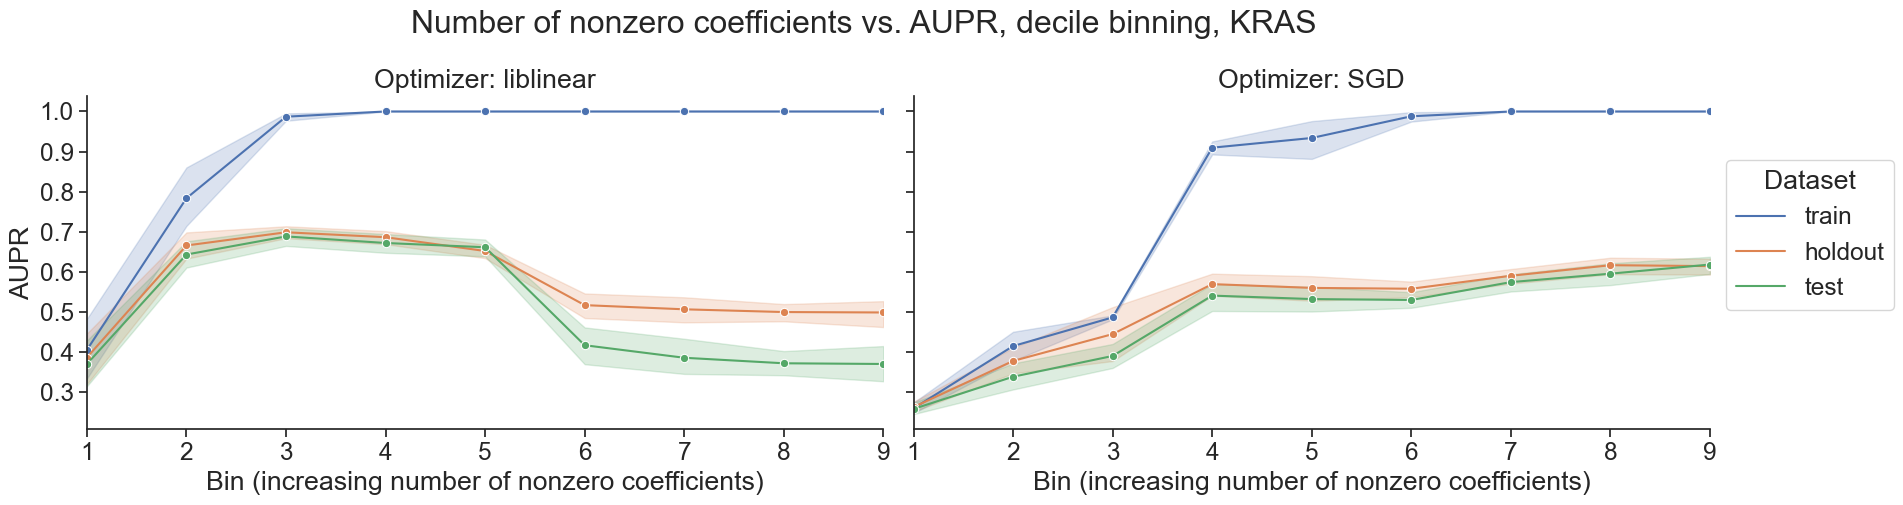

In [21]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=perf_coefs_df,
        x='nz_quantile', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.axes[0].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[0].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.axes[1].set_xlabel('Bin (increasing number of nonzero coefficients)')
    g.axes[1].set_xlim((0, perf_coefs_df.nz_quantile.max()))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(
        f'Number of nonzero coefficients vs. {metric.upper()}, decile binning, {plot_gene}',
        y=1.0
    )

plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_decile_vs_perf.svg'), bbox_inches='tight')

In [22]:
decile_perf_df = (perf_coefs_df
    [perf_coefs_df.data_type == 'test']
    .groupby(['optimizer', 'nz_quantile'])
    .agg(np.mean)
    .drop(columns=['seed', 'fold', 'lasso_param'])
)

print(decile_perf_df.shape)
decile_perf_df.loc['liblinear', :]

(18, 3)


,auroc,aupr,nz_coefs
nz_quantile,,,
1,0.622296,0.369266,3.588235
2,0.835058,0.642719,123.250000
3,0.851178,0.687956,686.521739
4,0.841011,0.671528,2486.833333
5,0.835550,0.660894,5484.611111
6,0.735699,0.416212,13364.500000
7,0.713054,0.384914,14485.500000
8,0.700369,0.371141,15258.375000
9,0.698671,0.369386,15363.875000


In [23]:
decile_perf_df.loc['SGD', :]

,auroc,aupr,nz_coefs
nz_quantile,,,
1,0.511310,0.257107,2.000000
2,0.643309,0.337535,120.384615
3,0.669645,0.389385,526.000000
4,0.791150,0.540150,2884.333333
5,0.784363,0.531519,5163.571429
6,0.775720,0.529224,11533.411765
7,0.800849,0.573835,14850.647059
8,0.811499,0.594921,15286.500000
9,0.816626,0.617739,15350.411765


In [24]:
# plot coefficient distributions for this seed/fold
plot_seed = 42
plot_fold = 0

In [25]:
ll_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
ll_mean_perf_df = (
  ll_perf_df[(ll_perf_df.data_type == 'cv') &
             (ll_perf_df.signal == 'signal')]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
      .sort_values(by='mean_aupr', ascending=False)
      .reset_index()
)
ll_mean_perf_df.head()

,lasso_param,mean_auroc,mean_aupr
0,0.05,0.867549,0.713160
1,0.1,0.866027,0.710577
2,0.5,0.859889,0.693575
3,1.0,0.859170,0.692704
4,5.0,0.855707,0.686330


In [26]:
sgd_top_df = []

# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
sgd_mean_perf_df = (
  sgd_perf_df[(sgd_perf_df.data_type == 'cv') &
              (sgd_perf_df.signal == 'signal')]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
      .sort_values(by='mean_aupr', ascending=False)
      .reset_index()
)
sgd_mean_perf_df.head()

,lasso_param,mean_auroc,mean_aupr
0,1e-06,0.825958,0.627485
1,5e-06,0.821636,0.610938
2,1e-05,0.817782,0.604276
3,5e-05,0.814746,0.598114
4,0.0001,0.808451,0.596409


In [27]:
ll_top_lasso_param = ll_mean_perf_df.iloc[0, :].lasso_param
sgd_top_lasso_param = sgd_mean_perf_df.iloc[0, :].lasso_param
print(ll_top_lasso_param, sgd_top_lasso_param)

0.05 1e-06


In [28]:
# get coefficient info for liblinear
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    if seed != plot_seed or lasso_param != ll_top_lasso_param:
        continue
    for fold_no, coefs in enumerate(coefs_list):
        if fold_no != plot_fold:
            continue
        ll_coefs_df = coefs
        
ll_coefs_df = (
    pd.DataFrame(ll_coefs_df)
      .rename(columns={0: 'feature', 1: 'coef'})
)
ll_coefs_df['optimizer'] = 'liblinear'
ll_coefs_df['abs+1'] = abs(ll_coefs_df.coef) + 1
ll_coefs_df.sort_values(by='abs+1', ascending=False).head(10)

,feature,coef,optimizer,abs+1
0,1848,0.39138,liblinear,1.39138
1,3845,0.33542,liblinear,1.33542
2,3783,0.25816,liblinear,1.25816
3,6907,0.20317,liblinear,1.20317
4,144363,0.19783,liblinear,1.19783
5,log10_mut,-0.19498,liblinear,1.19498
6,254013,0.19342,liblinear,1.19342
7,23303,0.18621,liblinear,1.18621
8,54707,-0.16585,liblinear,1.16585
9,3911,-0.14987,liblinear,1.14987


In [29]:
# get coefficient info for sgd
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    if seed != plot_seed or lasso_param != sgd_top_lasso_param:
        continue
        continue
    for fold_no, coefs in enumerate(coefs_list):
        if fold_no != plot_fold:
            continue
        sgd_coefs_df = coefs
        
sgd_coefs_df = (
    pd.DataFrame(sgd_coefs_df)
      .rename(columns={0: 'feature', 1: 'coef'})
)
sgd_coefs_df['optimizer'] = 'SGD'
sgd_coefs_df['abs+1'] = abs(sgd_coefs_df.coef) + 1
sgd_coefs_df.sort_values(by='abs+1', ascending=False).head(10)

,feature,coef,optimizer,abs+1
0,log10_mut,-26338.0,SGD,26339.0
1,338557,-4525.3,SGD,4526.3
2,10218,4170.4,SGD,4171.4
3,3845,4020.1,SGD,4021.1
4,1848,3824.0,SGD,3825.0
5,26127,3750.6,SGD,3751.6
6,144363,3623.2,SGD,3624.2
7,200008,3468.2,SGD,3469.2
8,4023,3417.2,SGD,3418.2
9,125875,3408.3,SGD,3409.3


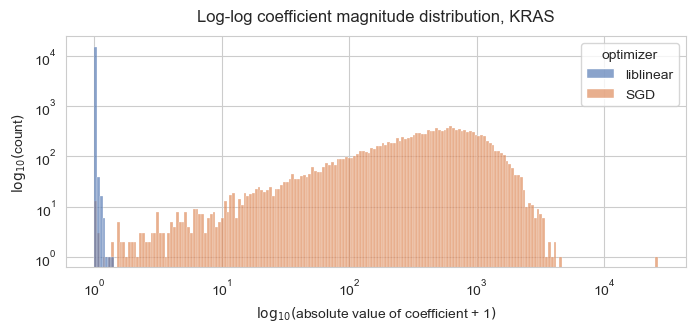

In [32]:
sns.set({'figure.figsize': (8, 3)})
sns.set_style('whitegrid')

coefs_df = pd.concat((ll_coefs_df, sgd_coefs_df)).reset_index(drop=True)

sns.histplot(data=coefs_df, x='abs+1', hue='optimizer', bins=200,
             log_scale=(True, True), alpha=0.65)
plt.xlabel(r'$\log_{10}($absolute value of coefficient + 1$)$')
plt.ylabel(r'$\log_{10}($count$)$')
plt.title(f'Log-log coefficient magnitude distribution, {plot_gene}', y=1.03)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefficient_magnitudes.svg'),
                bbox_inches='tight')

Text(0.5, 0, 'Coefficient')

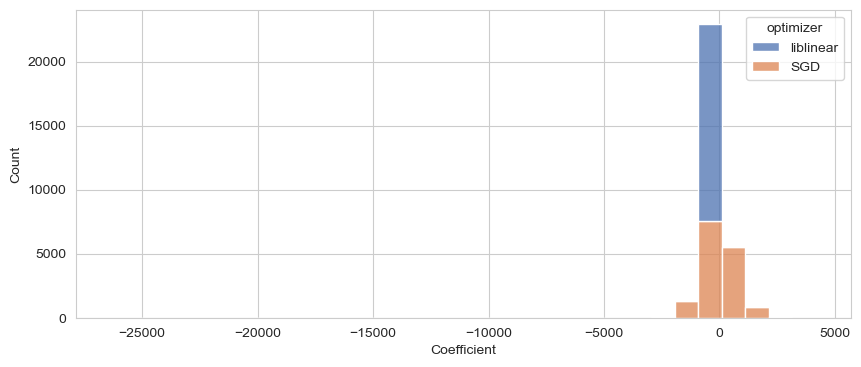

In [31]:
sns.set({'figure.figsize': (10, 4)})
sns.set_style('whitegrid')

coefs_df = pd.concat((ll_coefs_df, sgd_coefs_df)).reset_index(drop=True)

sns.histplot(data=coefs_df, x='coef', hue='optimizer', bins=30, multiple='stack')
plt.xlabel('Coefficient')